In [1]:
import numpy as np
import pandas as pd
% matplotlib inline

In [2]:
N = 1000
p = 0.02

In [3]:
num_observed = np.random.binomial(N, p)
p_hat = num_observed * 1.0 / N
print(p_hat)

0.024


### bootstrap confidence interval

Here's a 95% bootstrap confidence interval obtained by resampling 1,000 points 100,000 times from the sample distribution.

In [4]:
def bootstrap_confidence_interval(p_hat, N):
    BIG_NUMBER = 100000 # this is pretty arbitrary
    samples = pd.Series(np.random.binomial(N, p_hat, BIG_NUMBER) / N)
    return np.percentile(samples, 5), np.percentile(samples, 95)

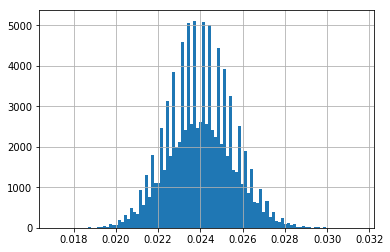

In [5]:
# we can draw a histogram!
pd.Series(np.random.binomial(10000, p_hat, 100000) / 10000).hist(bins=101)

In [6]:
bootstrap_confidence_interval(p_hat, N)

(0.016, 0.032000000000000001)

### normal confidence interval

Here's a 95% confidence interval based on the central limit theorem (from [Wikipedia](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval)):

$$\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p}}{n}}$$

This seems to be wider and much more likely to contain the correct probability

In [7]:
def normal_confidence_interval(p_hat, n):
    z = 1.96 # constant for the 95th percentile confidence interval
    delta = z * np.sqrt(p_hat * (1-p_hat) / n)
    return (p_hat - delta, p_hat + delta)

In [8]:
normal_confidence_interval(p_hat, N)

(0.014513923972474183, 0.033486076027525818)

### wilson score interval

Here's another one from the same [wikipedia page](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval)

$$  \frac{\hat p+\frac{z^2}{2n}}{1+\frac{z^2}{n}}
\pm
\frac{z}{1+\frac{z^2}{n}}\sqrt{\frac{\hat p(1-\hat p)}{n}+\frac{z^2}{4n^2}}
$$

In [9]:
def wilson_score_interval(p_hat, n):
    z = 1.96
    center = (p_hat + z**2 / (2*n)) / (1 + z**2 / n)
    delta = (z / (1 + z**2 / n)) * np.sqrt(p_hat * (1-p_hat)/n + z**2 / (4*n**2))
    return (center - delta, center + delta)

In [10]:
wilson_score_interval(p_hat, N)

(0.016180052367186296, 0.035463155087057489)

# how likely is each confidence interval to contain the real p?

we'd expect the answer to be about 95%. Is it? Let's see!

In [11]:
def contains_p(interval, p):
    return interval[0] <= p and interval[1] >= p

In [13]:
bootstrap_successes = 0
wilson_successes = 0
normal_successes = 0

repeats = 1000

for i in range(1, repeats):
    p_hat = np.random.binomial(N, p) * 1.0 / N
    if contains_p(bootstrap_confidence_interval(p_hat, N), p):
        bootstrap_successes += 1
    if contains_p(wilson_score_interval(p_hat, N), p):
        wilson_successes += 1
    if contains_p(normal_confidence_interval(p_hat, N), p):
        normal_successes += 1


In [14]:
print("Bootstrap success ratio:", bootstrap_successes / repeats)
print("Wilson success ratio:", wilson_successes / repeats)
print("Normal success ratio:", normal_successes / repeats)

Bootstrap success ratio: 0.906
Wilson success ratio: 0.948
Normal success ratio: 0.954


So it seems like the bootstrap confidence interval might be a little worse than the wilson / normal confidence intervals, in this case: the 'real' probability is only contained in the bootstrap interval ~90% of the time, not 95%.